# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Date created:** 2021/06/25<br>
**Last modified:** 2021/08/05<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [1]:
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter=",")
    y = data[:, -1]
    x = data[:, 0:-1]
    return x, y.astype(int)

x_train, y_train = readucr("datos_train.csv")
x_test, y_test = readucr("datos_test.csv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [3]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [26]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu",kernel_regularizer='l1')(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train and evaluate

In [27]:
batch=64

In [28]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=3,
    ff_dim=3,
    num_transformer_blocks=3,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=batch,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
layer_normalization_8 (LayerNor (None, 4, 1)         2           input_3[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_4 (MultiHe (None, 4, 1)         10753       layer_normalization_8[0][0]      
                                                                 layer_normalization_8[0][0]      
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 4, 1)         0           multi_head_attention_4[0][0

[0.013947596773505211, 0.9979507923126221]

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


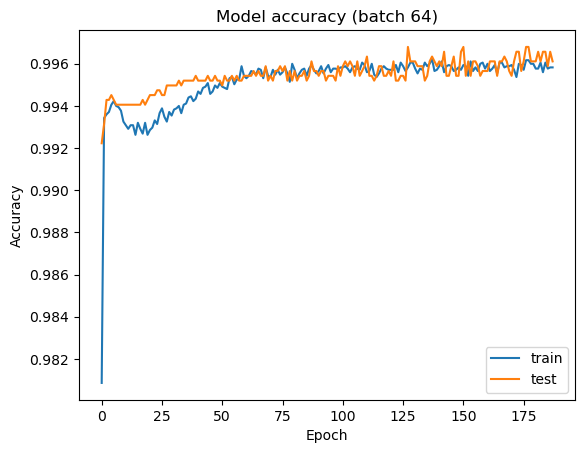

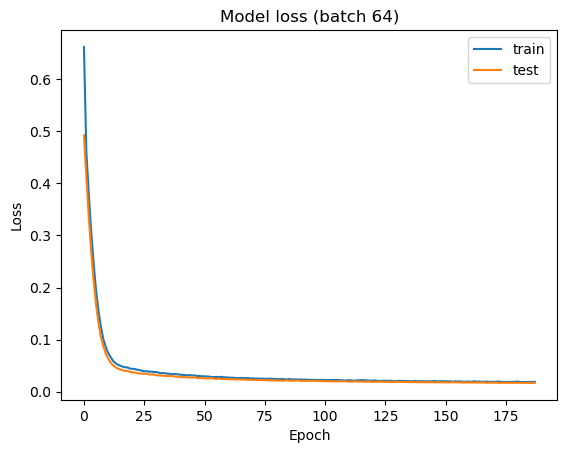

In [29]:

# list all data in history
print(history.history.keys())
# summarize history for sparse_categorical_accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy (batch {0})'.format(batch))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (batch {0})'.format(batch))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [30]:

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

In [31]:
filepath = './binary_class_model_{0}'.format(batch)

In [32]:
model.save('binary_class_model_{0}.h5'.format(batch))
save_model(model, filepath)

INFO:tensorflow:Assets written to: ./binary_class_model_64\assets


INFO:tensorflow:Assets written to: ./binary_class_model_64\assets


In [33]:
#new_model = keras.models.load_model('binary_class_model_200.h5')
model = load_model('./binary_class_model', compile = True)

In [34]:
# [0.0,0.0,0.0,0.0],
# [2.4,0.0,0.0,0.0],
# [0.0,0.1,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.1,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [1.2,0.0,0.1,0.0,0.0],
# [2.9,29.9,2.3,0.1,1.0],
# [3.1,37.6,2.1,1.1,1.0],
# [1.4,2.2,0.2,0.2,0.0],
# [0.0,0.1,0.0,0.0,0.0],
# [0.0,0.0,0.0,0.0,0.0],
# [0.2,0.0,0.0,0.0,0.0],
# [0.0,0.0,0.1,0.0,0.0]


use_samples = [
[0.0,0.0,0.0,0.0],
[2.4,0.0,0.0,0.0],
[0.0,0.1,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.1,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.0,0.0,0.0,0.0],
[1.2,0.0,0.1,0.0],
[2.9,29.9,2.3,0.1],
[3.1,37.6,2.1,1.1],
[1.4,2.2,0.2,0.2],
[0.0,0.1,0.0,0.0],
[0.0,0.0,0.0,0.0],
[0.2,0.0,0.0,0.0],
[0.0,0.0,0.1,0.0]
    ]

# Convert into Numpy array
samples_to_predict = np.array(use_samples)
print(samples_to_predict.shape)

# Generate predictions for samples
# predictions = np.around(model.predict(samples_to_predict))
predictions = model.predict(samples_to_predict)
predictions

(24, 4)


array([[9.9997401e-01, 2.6000913e-05],
       [9.9984372e-01, 1.5627146e-04],
       [9.9997211e-01, 2.7874828e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997211e-01, 2.7918193e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9993479e-01, 6.5168089e-05],
       [6.5365391e-05, 9.9993467e-01],
       [2.0147736e-06, 9.9999797e-01],
       [9.9945158e-01, 5.4841547e-04],
       [9.9997211e-01, 2.7874828e-05],
       [9.9997401e-01, 2.6000913e-05],
       [9.9997008e-01, 2.9918672e-05],
       [9.9997234e-01, 2.7634262e-05]], dtype=float32)

In [35]:
label_samples=[
'2019-06-30 00:00:00',
'2019-06-30 01:00:00',
'2019-06-30 02:00:00',
'2019-06-30 03:00:00',
'2019-06-30 04:00:00',
'2019-06-30 05:00:00',
'2019-06-30 06:00:00',
'2019-06-30 07:00:00',
'2019-06-30 08:00:00',
'2019-06-30 09:00:00',
'2019-06-30 10:00:00',
'2019-06-30 11:00:00',
'2019-06-30 12:00:00',
'2019-06-30 13:00:00',
'2019-06-30 14:00:00',
'2019-06-30 15:00:00',
'2019-06-30 16:00:00',
'2019-06-30 17:00:00',
'2019-06-30 18:00:00',
'2019-06-30 19:00:00',
'2019-06-30 20:00:00',
'2019-06-30 21:00:00',
'2019-06-30 22:00:00',
'2019-06-30 23:00:00']

In [36]:
predictions_list = [predictions.flat[i] for i in range(1,len(predictions.flat),2)]
predictions_list

[2.6000913e-05,
 0.00015627146,
 2.7874828e-05,
 2.6000913e-05,
 2.6000913e-05,
 2.7918193e-05,
 2.6000913e-05,
 2.6000913e-05,
 2.6000913e-05,
 2.6000913e-05,
 2.6000913e-05,
 2.6000913e-05,
 2.6000913e-05,
 2.6000913e-05,
 2.6000913e-05,
 2.6000913e-05,
 6.516809e-05,
 0.9999347,
 0.999998,
 0.00054841547,
 2.7874828e-05,
 2.6000913e-05,
 2.9918672e-05,
 2.7634262e-05]

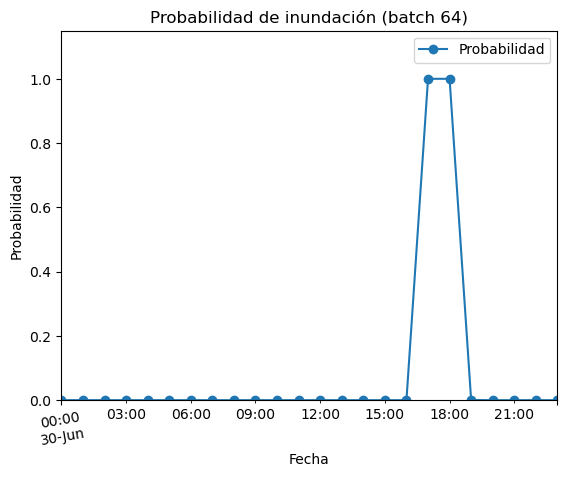

In [37]:
df=pd.DataFrame(list(zip(label_samples,predictions_list)),columns=['Fecha','Probabilidad'])
df["Fecha"]= pd.to_datetime(df["Fecha"])
df = df.set_index('Fecha')
df.plot(style="-o")
#plt.plot(label_samples,predictions_list)
plt.title('Probabilidad de inundación (batch {0})'.format(batch))
plt.tick_params(axis='x', rotation=10)
plt.xlabel('Fecha')
plt.ylabel('Probabilidad')
plt.ylim([0,1.15])
plt.show()